In [16]:

from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

import tensorflow as tf

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

In [18]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()


['/job:localhost/replica:0/task:0/device:GPU:0']

In [19]:

with tf.device('/cpu:0'):
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(None, 40, 40, 1),
                       padding='same', return_sequences=True))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    seq.add(BatchNormalization())


    #TODO: data_format, conv3D, how to apply kernel_size
    seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
                   activation='sigmoid',
                   padding='same', data_format='channels_last'))
    seq.compile(loss='binary_crossentropy', optimizer='adadelta')


# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

noisy_movies, shifted_movies = generate_movies(n_samples=1200)

In [22]:
noisy_movies[:1000].shape, shifted_movies.shape

seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=20,
        epochs=10, validation_split=0.05)

((1000, 15, 40, 40, 1), (1200, 15, 40, 40, 1))

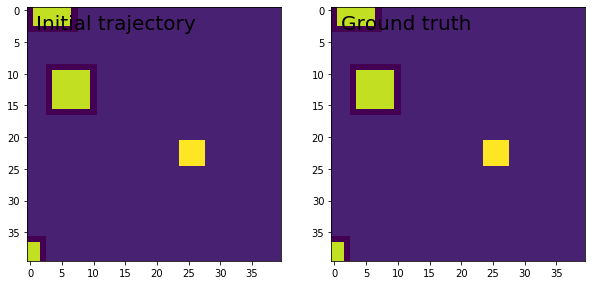

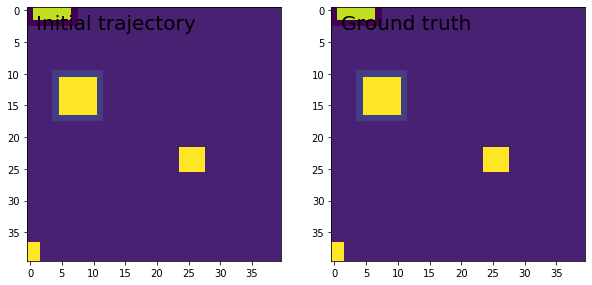

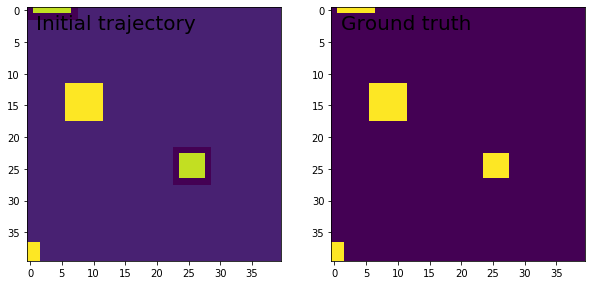

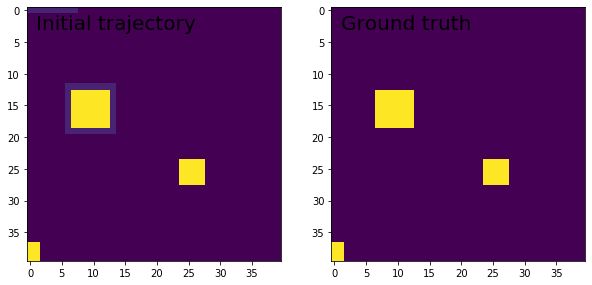

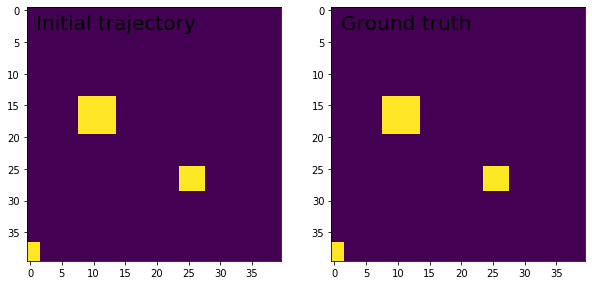

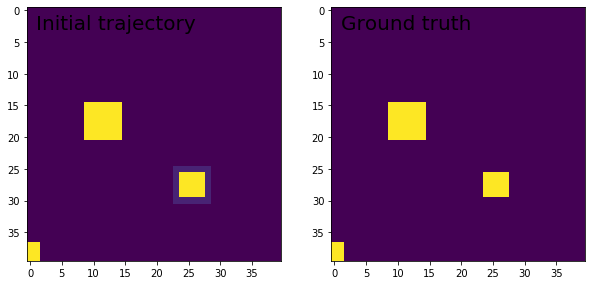

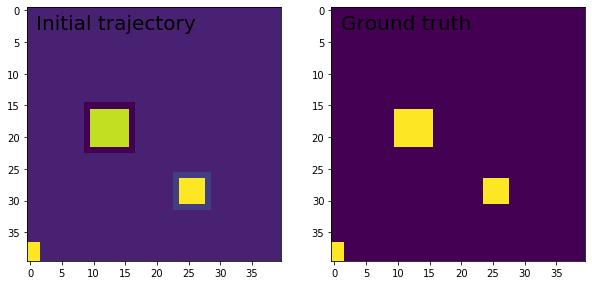

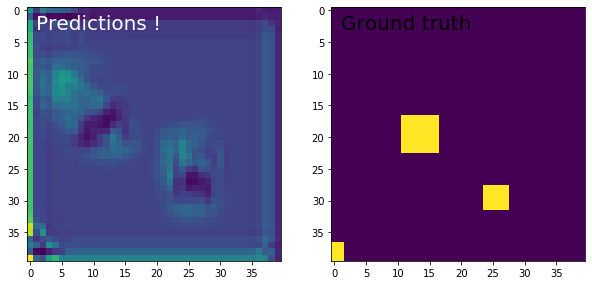

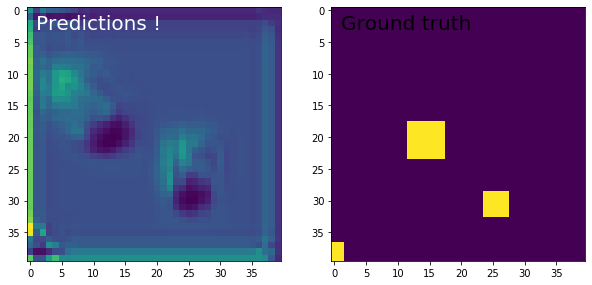

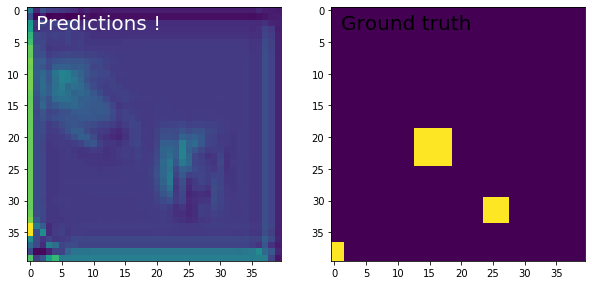

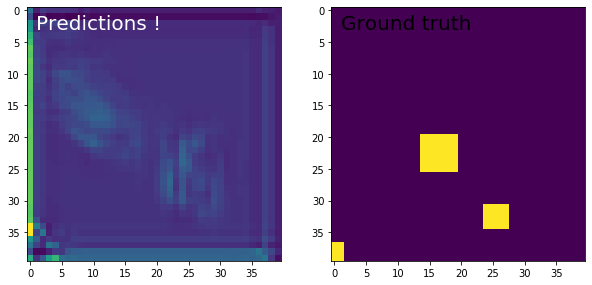

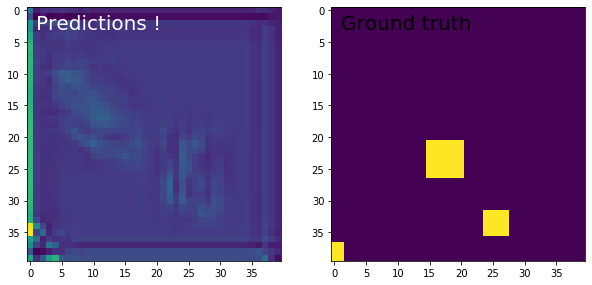

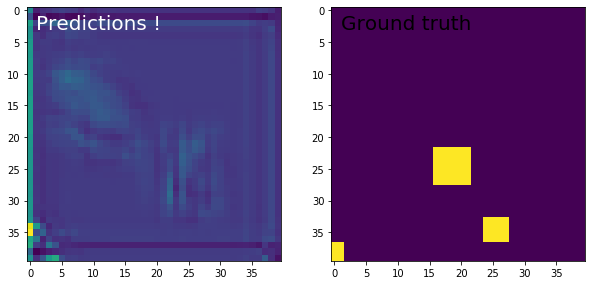

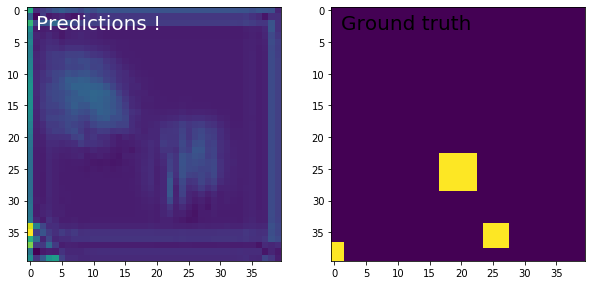

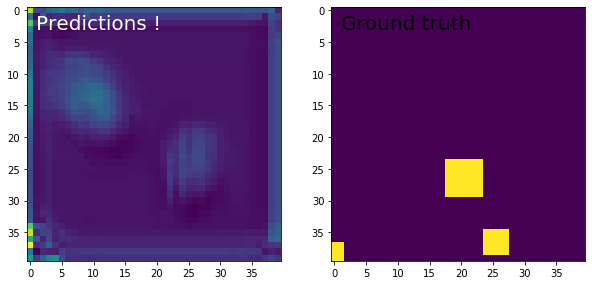

In [14]:



# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))